In [1]:
from functools import partial
from itertools import chain

from tqdm.auto import tqdm
from matplotlib import pyplot as plt

import torch
from torch.nn import Sequential, Flatten, LazyLinear, LazyBatchNorm1d, LeakyReLU
from torch.utils.data import DataLoader

from lib.nn import FilesDataset, Head, NRE

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
from glob import glob
from pathlib import Path

N = 100
DATA_GEN = f'{N}-cosmo-ir'
EXPERIMENT_NAME = 'hpmvn'
SUFFIX = ''  # '-negrenyi'
SAVENAME = f'{EXPERIMENT_NAME}{SUFFIX}'
RESDIR = Path(f'res-{DATA_GEN}')
TRAINDIR = RESDIR / 'nntrain'

NRENAME = f'res-{DATA_GEN}/{SAVENAME}-nre.pt'
LOSSESNAME = f'res-{DATA_GEN}/{SAVENAME}-nre-losses.pt'

dataset = FilesDataset(glob(str(TRAINDIR / '*.pt')))

In [3]:
head_fn = partial(Head, Sequential(
    Flatten(-2),
    LazyBatchNorm1d(momentum=None, track_running_stats=True),
    LazyLinear(512), LeakyReLU(),
    LazyLinear(256), LeakyReLU(),
    LazyLinear(256), LeakyReLU(),
    LazyLinear(128), LeakyReLU(),
    LazyLinear(128), LeakyReLU(),
    LazyLinear(128)
))

/usr/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
nre_fn = partial(NRE, features=128, net=Sequential(
    LeakyReLU(), LazyLinear(128),
    LeakyReLU(), LazyLinear(128),
    LeakyReLU(), LazyLinear(128),
    LeakyReLU(), LazyLinear(1),
))

In [5]:
head, nre = head_fn(), nre_fn()
losses = []

In [7]:
from contextlib import suppress
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam


loader = DataLoader(dataset, batch_size=128)
loss_func = BCEWithLogitsLoss()
optim = Adam(chain(head.parameters(), nre.parameters()), lr=1e-4)
with suppress(KeyboardInterrupt):
    for i, (params, obs) in (tq := tqdm(zip(range(_n := 5000), loader), total=_n)):
        optim.zero_grad(), head.train(), nre.train()
        torch.cuda.empty_cache()

        theta, x = head(params, obs)
        theta_shuffled = theta[torch.randperm(len(theta))]

        res = nre(theta, x)
        res_shuffled = nre(theta_shuffled, x)

        loss = loss_func(res, torch.ones_like(res)) + loss_func(res_shuffled, torch.zeros_like(res_shuffled))

        losses.append(l := loss.item())
        tq.set_postfix_str(str(l))

        loss.backward()
        optim.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
torch.save((head, nre), NRENAME)
torch.save(losses, LOSSESNAME)

In [6]:
head, nre = torch.load(NRENAME)
losses = torch.load(LOSSESNAME)
loader = DataLoader(dataset, batch_size=16)

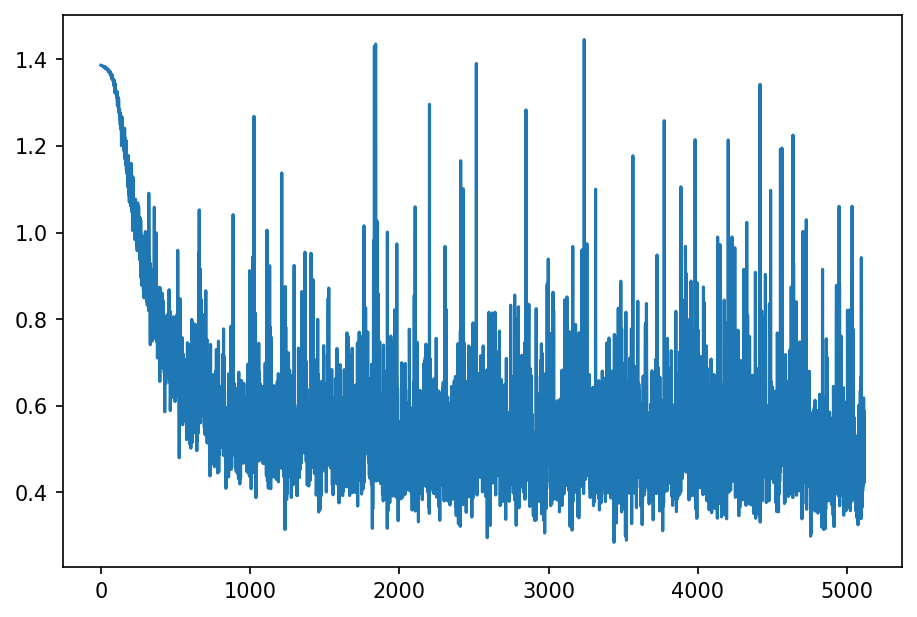

In [8]:
plt.plot(losses)

In [9]:
from collections import OrderedDict
from torch._vmap_internals import vmap
from clipppy.patches import torch_numpy


prior_C_extent = (0.1, 0.5, 0.5, 0.9)

imkwargs = dict(origin='lower', extent=prior_C_extent)
Ode0, Om0 = torch.meshgrid(torch.linspace(*prior_C_extent[2:], 41),
                           torch.linspace(*prior_C_extent[:2], 41))

test_params, test_obs = next(iter(loader))

@vmap
def func(Om0, Ode0):
    return nre(*head(OrderedDict((('Om0', Om0), ('Ode0', Ode0))), test_obs))

head.eval(), nre.eval()
ress = func(*(_.unsqueeze(-1).expand(*_.shape, loader.batch_size).flatten(0, 1) for _ in (Om0, Ode0))).unflatten(0, Om0.shape[:2]).squeeze(-1).movedim(-1, 0)

/tmp/ipykernel_257518/629724637.py:15: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  def func(Om0, Ode0):


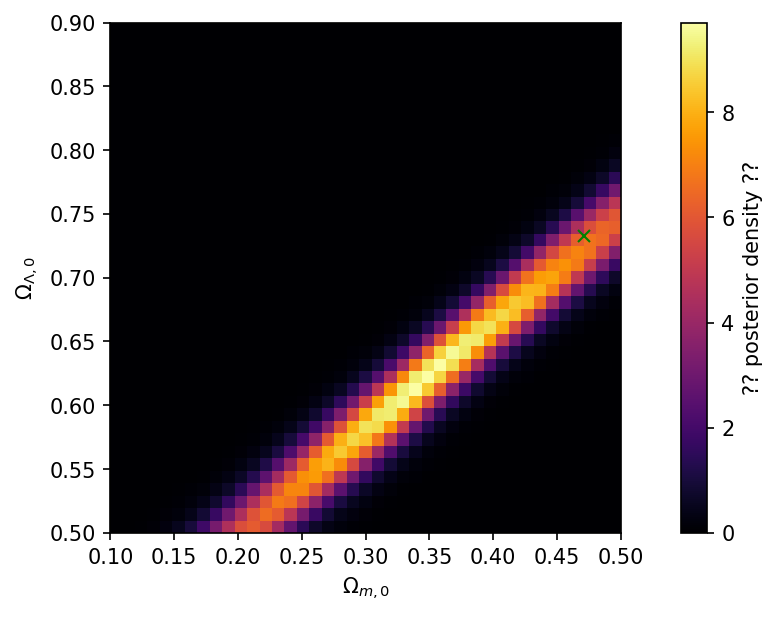

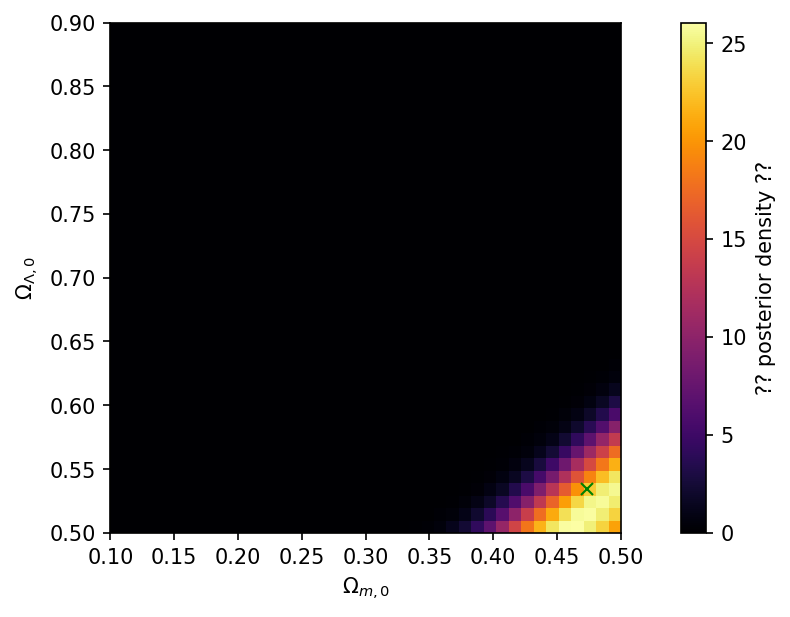

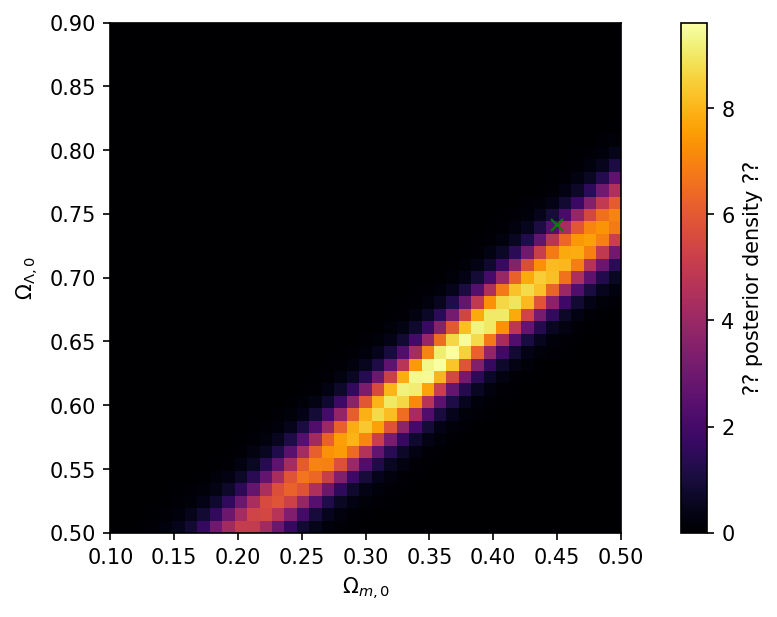

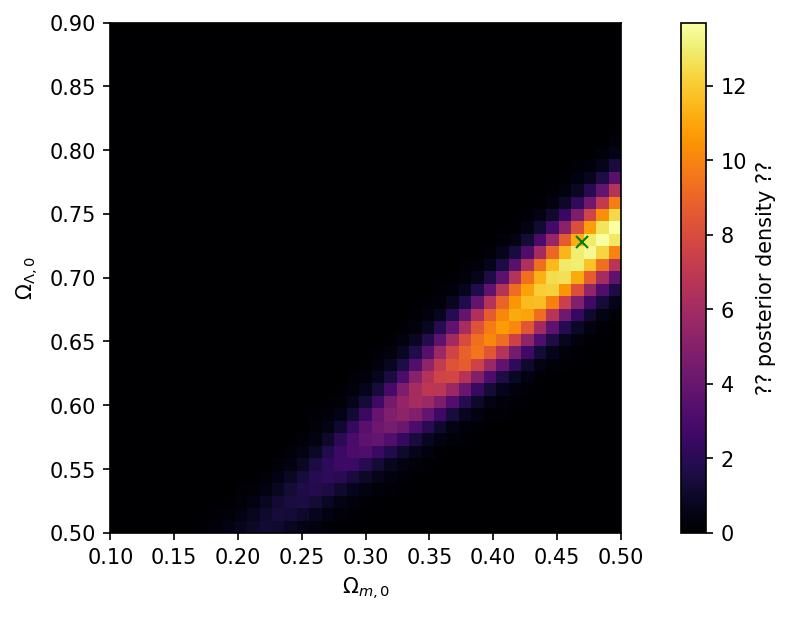

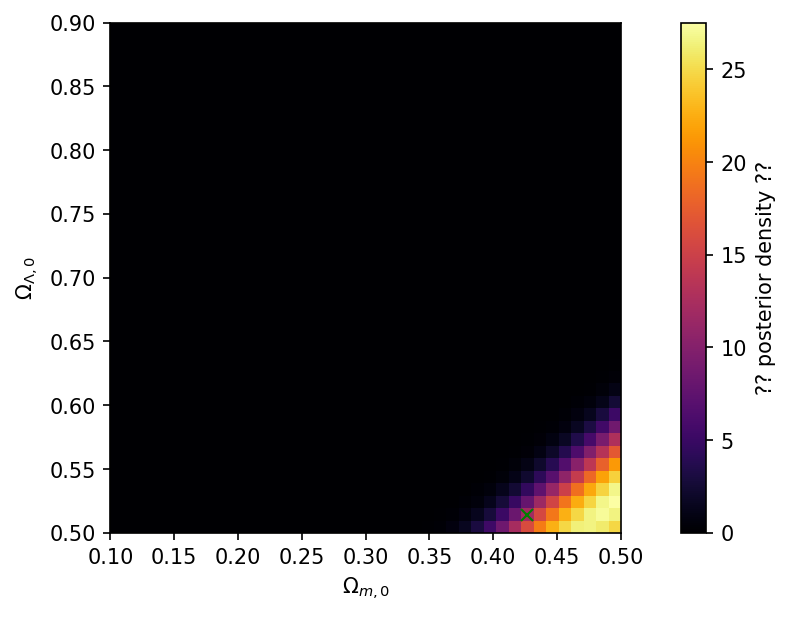

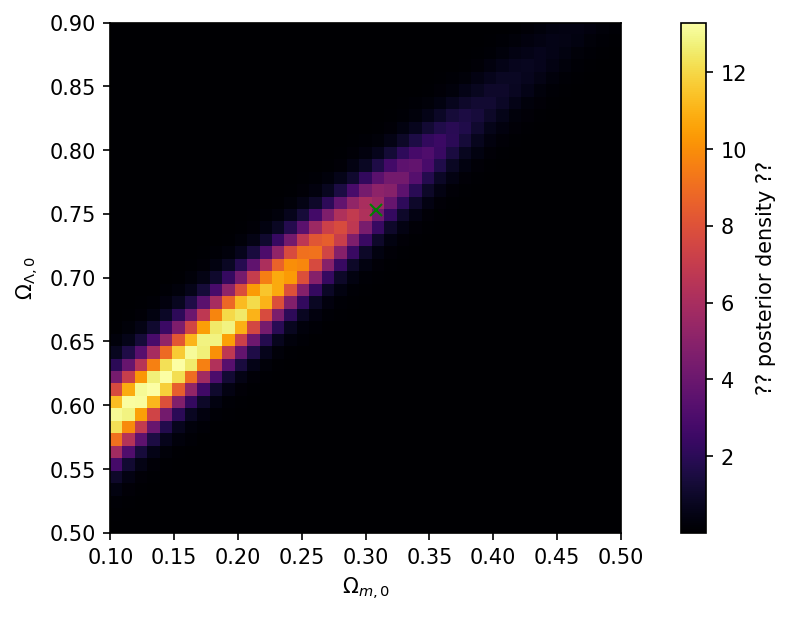

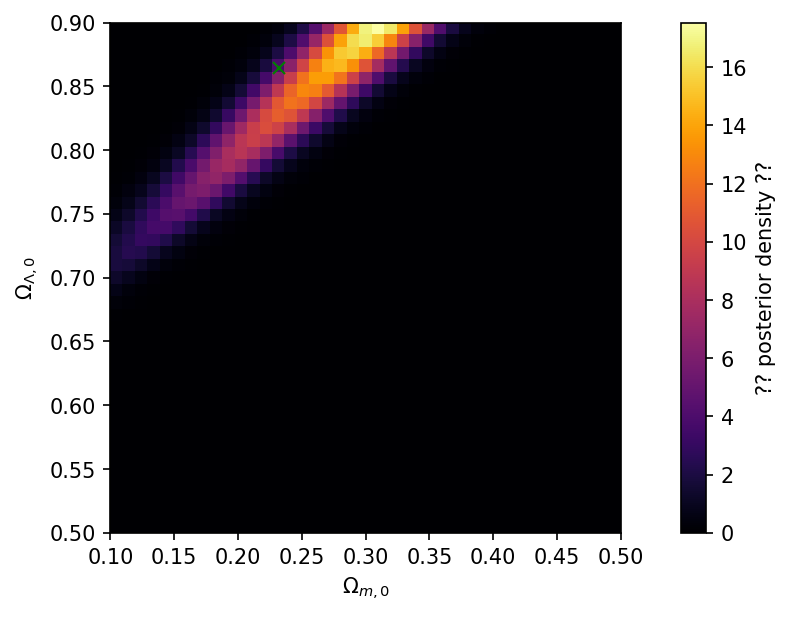

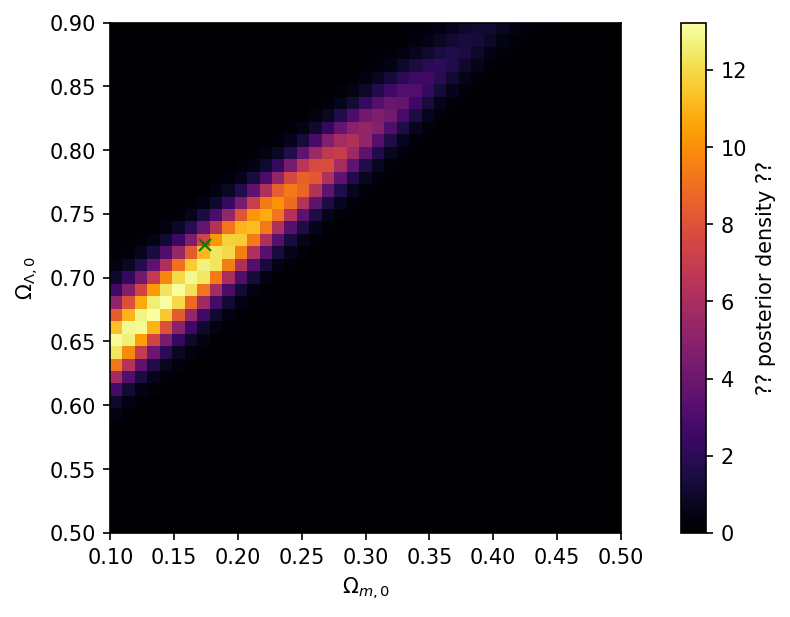

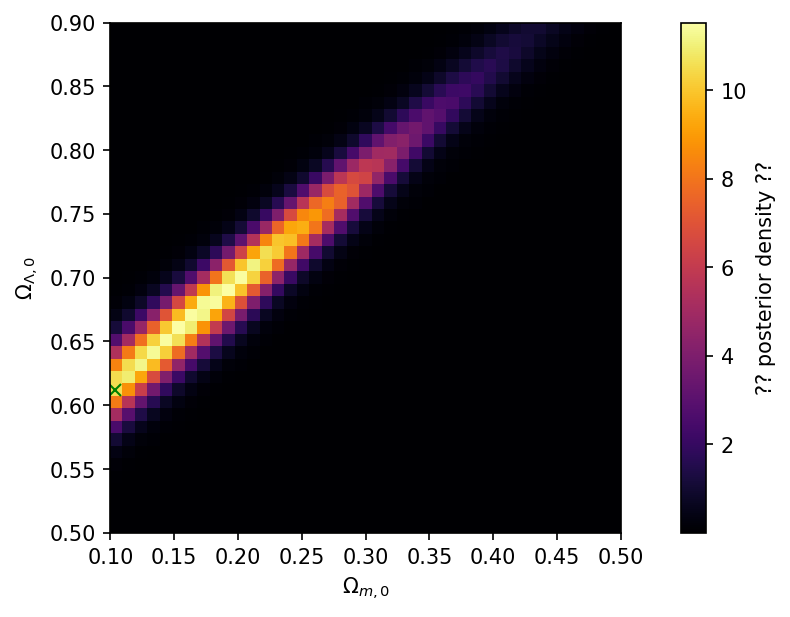

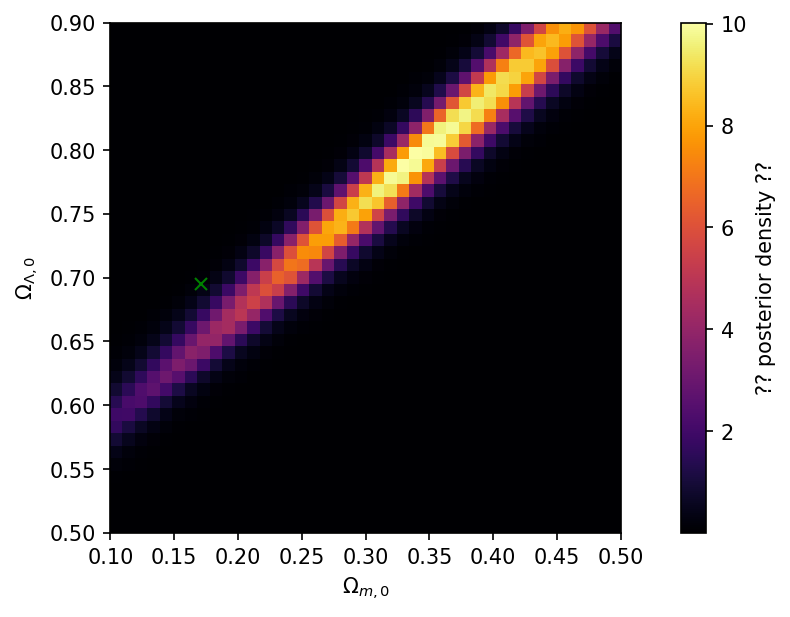

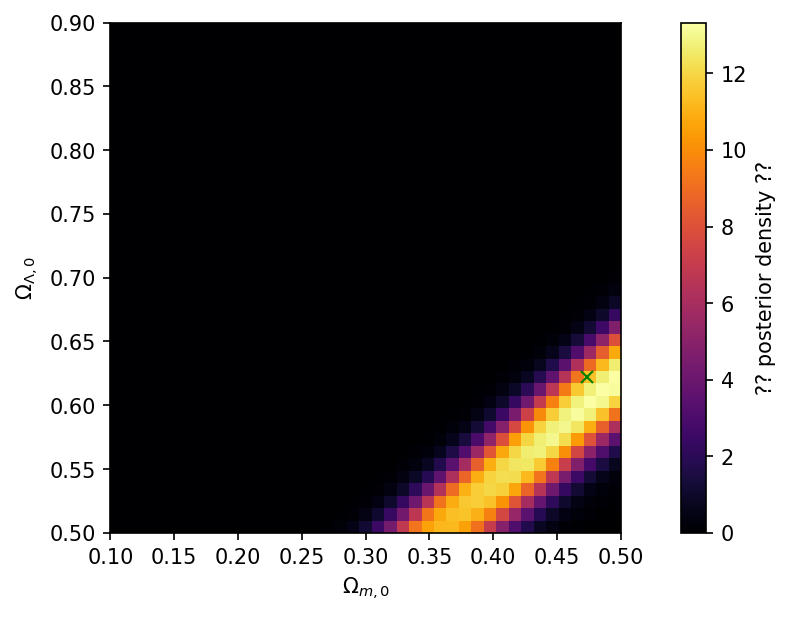

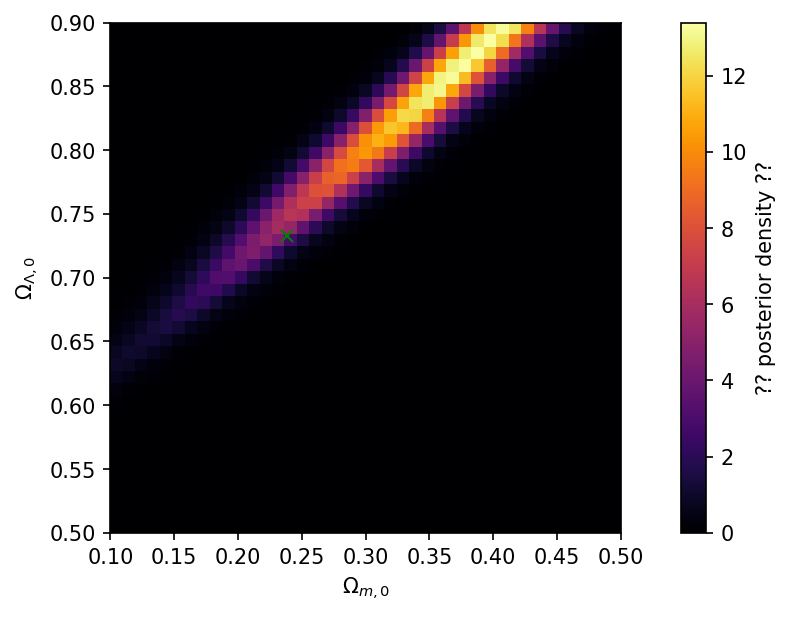

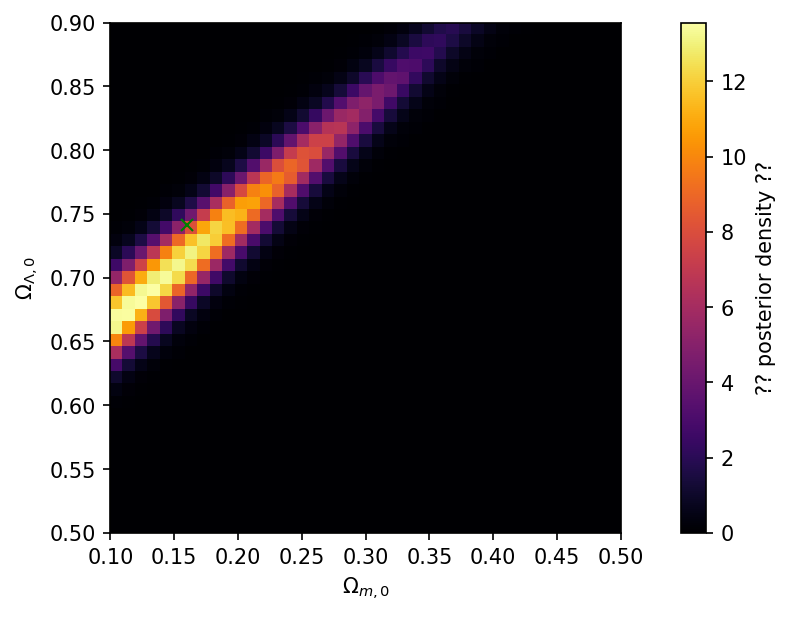

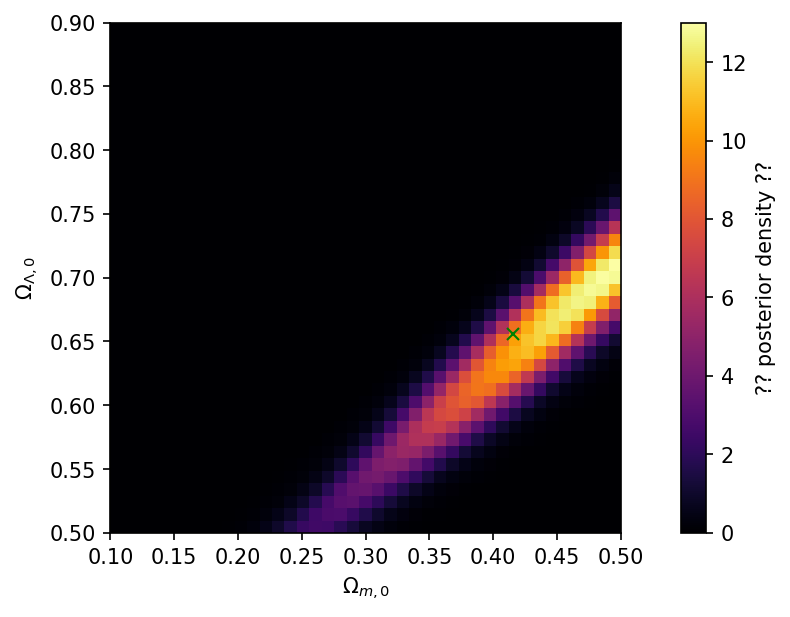

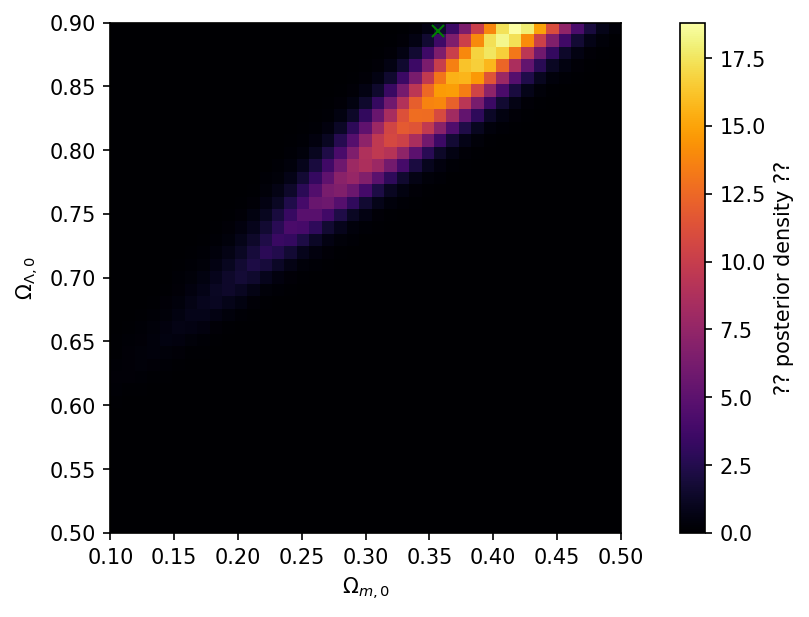

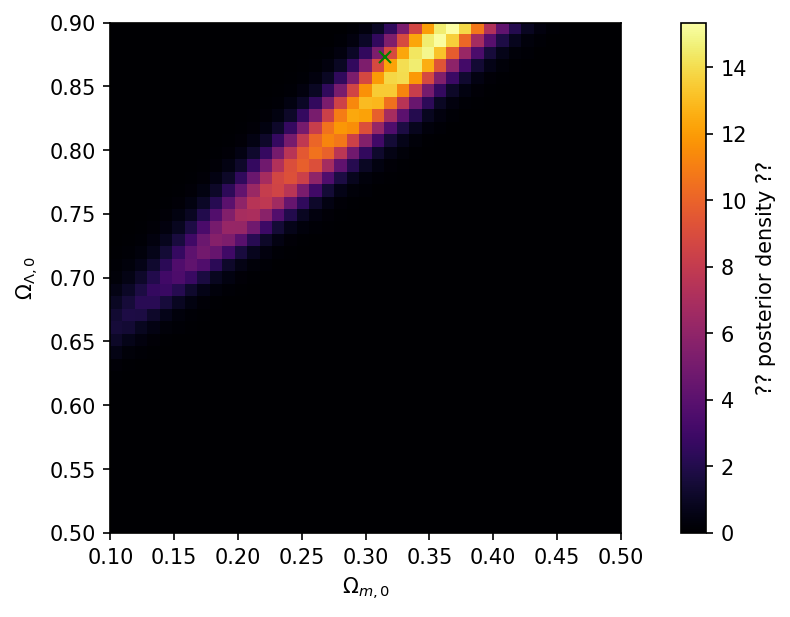

In [10]:
from operator import itemgetter


head.eval(), nre.eval()

for i, (_Om0, _Ode0, res) in enumerate(zip(*itemgetter('Om0', 'Ode0')(test_params), ress[:16])):
    post = res.exp()
    # post /= post.max()

    plt.figure()

    plt.imshow(post, **imkwargs, cmap='inferno')
    plt.plot(_Om0, _Ode0, 'gx')

    plt.xlabel(r'$\Omega_{m, 0}$')
    plt.ylabel(r'$\Omega_{\Lambda, 0}$')

    cax = plt.colorbar()
    cax.set_label('?? posterior density ??')

    # plt.savefig(f'res-{DATA_GEN}/plots/nre/{SAVENAME}-cosmopost-{i}.png')
    # plt.close()

In [10]:
ress.exp().mean((-2, -1))

tensor([0.7809, 0.8249, 0.7504, 0.7987, 0.7388, 0.7608, 0.8842, 0.8614],
       grad_fn=<MeanBackward1>)